# **Modeling Test #3**
### 줄거리 Clustering w/ KoBERT & KoBART

<br><br><hr>

## **✅ 00. 기본 설정**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메시지 출력 X
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 한글 font 설정
import platform
import matplotlib.font_manager as fm

#matplotlib 패키지 한글 깨짐 처리 시작
#------------------------------------------------------------------------------------
# 운영체제별 한글 폰트 설정

if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
    
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [3]:
# 글씨 선명하게 출력하는 설정

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

<br><br><br><hr>

## **✅ 01. 데이터 불러오기**

In [4]:
movies = pd.read_csv('..\data\movies_4000_tmdb_genre.csv')
print(movies.shape)   # (4241, 6)
movies.head(3)

(4241, 6)


,asset_nm_전처리,ct_cl,genre_of_ct_cl,summary_최신순,최신순,genre_tmdb
0,귀멸의 칼날: 남매의 연,영화,애니메이션,혈귀의 습격으로 가족을 잃은 소년 ‘탄지로’. 유일하게 살아남은 여동생 ‘네즈코’마...,2019-03-29,"Animation, Action, Fantasy, Thriller"
1,색에 놀다,영화,에로틱,하얀 색의 순수하고 착한 사랑을 꿈꾸는 25살 모태 솔로 지수. 그녀의 짝사랑 상대...,2017-01-01,"Thriller, Drama, Romance"
2,돌이킬 수 없는 주말,영화,공포/스릴러,베키는 결혼을 앞두고 친구 수잔과 함께 다트무어로 여행을 떠난다. 그곳에서 신비한 ...,2015-09-18,"Drama, Horror, Mystery"


<br>

#### *>> 장르가 '성인' 또는 '기타'인 행와 장르의 value_counts가 40개 미만인 행은 삭제*

In [5]:
# 각 장르의 수 를 genre_counts 변수에 저장
genre_counts = movies['genre_of_ct_cl'].value_counts()

In [6]:
# 삭제할 조건 생성
delete_conditions = (movies['genre_of_ct_cl'] == '성인') | (movies['genre_of_ct_cl'] == '기타') | (movies['genre_of_ct_cl'].isin(genre_counts[genre_counts < 40].index))
filtered_movies = movies[~delete_conditions]

In [7]:
# 결과 확인
print(filtered_movies.shape)
filtered_movies['genre_of_ct_cl'].value_counts()

### (4241, 6) >> (3675, 6) >> 566개의 행 삭제

(3675, 6)


genre_of_ct_cl
드라마        1011
액션/어드벤쳐     977
공포/스릴러      639
멜로          329
코미디         265
애니메이션       169
SF/환타지      159
다큐멘터리       126
Name: count, dtype: int64

<br>

#### *>> 사용하지 않을 열 drop*

In [8]:
col_to_drop = ['ct_cl', '최신순', 'genre_tmdb']
drop_movies = filtered_movies.drop(columns=col_to_drop, axis=1)

drop_movies.head(3)

,asset_nm_전처리,genre_of_ct_cl,summary_최신순
0,귀멸의 칼날: 남매의 연,애니메이션,혈귀의 습격으로 가족을 잃은 소년 ‘탄지로’. 유일하게 살아남은 여동생 ‘네즈코’마...
2,돌이킬 수 없는 주말,공포/스릴러,베키는 결혼을 앞두고 친구 수잔과 함께 다트무어로 여행을 떠난다. 그곳에서 신비한 ...
3,섹스 앤 머니,액션/어드벤쳐,갱단 두목 페페는 라이벌 갱단 두목 조조와 세력 다툼을 벌이다 쫓기는 신세가 된다....


<br><br><br><hr>

## **✅02. 특수문자/숫자 제거**

In [9]:
import re

In [10]:
# 정규표현식을 이용해 숫자를 공백으로 변경 (정규 표현식으로 \d는 숫자 의미)
drop_movies['summary_최신순'] = drop_movies['summary_최신순'].apply(lambda x : re.sub(r"\d+", "", x))

In [11]:
# 정규표현식을 이용해 특수문자를 공백으로 변경
drop_movies['summary_최신순'] = drop_movies['summary_최신순'].apply(lambda x: re.sub(r"[^가-힣a-zA-Z0-9\s]", "", x))

In [12]:
# 인덱스 정렬
# 데이터 인덱스 재설정
drop_movies = drop_movies.reset_index(drop=True)
drop_movies.head(3)

,asset_nm_전처리,genre_of_ct_cl,summary_최신순
0,귀멸의 칼날: 남매의 연,애니메이션,혈귀의 습격으로 가족을 잃은 소년 탄지로 유일하게 살아남은 여동생 네즈코마저 혈귀로...
1,돌이킬 수 없는 주말,공포/스릴러,베키는 결혼을 앞두고 친구 수잔과 함께 다트무어로 여행을 떠난다 그곳에서 신비한 매...
2,섹스 앤 머니,액션/어드벤쳐,갱단 두목 페페는 라이벌 갱단 두목 조조와 세력 다툼을 벌이다 쫓기는 신세가 된다 ...


<br><br><br><hr>

## **✅ 03. 토크나이저/모델 불러오기**

<br>

### ***KoBART--------------------------------------------------------***
- SKT에서 공개한 pretrained KoBART 소스를 활용하여 클러스터링 알고리즘으로 VOD 줄거리 군집화
- 참고 동영상 : https://youtu.be/BgVXl61GC5E?feature=shared

In [35]:
# pip install git+https://github.com/SKT-AI/KoBART#egg=kobart

In [13]:
from transformers import BartModel
from kobart import get_pytorch_kobart_model, get_kobart_tokenizer

In [14]:
# KoBART 모델과 토크나이저 불러오기
kobart_tokenizer = get_kobart_tokenizer()
kobart_model = BartModel.from_pretrained(get_pytorch_kobart_model())

# 이미 다운로드되어서 캐시 파일에 있던 걸 불러옴

using cached model. c:\workspaces\10_proj\model-test\model_test\.cache\kobart_base_tokenizer_cased_cf74400bce.zip


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


using cached model. c:\workspaces\10_proj\model-test\model_test\.cache\kobart_base_cased_ff4bda5738.zip


<br><br><br>

### ***KoBERT--------------------------------------------------------***
- SKT의 KoBERT 소스를 활용하여 클러스터링 알고리즘으로 VOD 줄거리 군집화
- `git+https://git@github.com/SKTBrain/KoBERT.git@master`
- 참고 github: https://github.com/SKTBrain/KoBERT
- **huggingface transformers API**: https://github.com/SKTBrain/KoBERT/tree/master/kobert_hf

In [38]:
# !pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

# requirement list
'''
Python >= 3.6
PyTorch >= 1.8.1
transformers >= 4.8.2
sentencepiece >= 0.1.91
'''

'\nPython >= 3.6\nPyTorch >= 1.8.1\ntransformers >= 4.8.2\nsentencepiece >= 0.1.91\n'

In [39]:
from transformers import BertModel
from kobert_tokenizer import KoBERTTokenizer

In [40]:
kobert_tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
kobert_model = BertModel.from_pretrained('skt/kobert-base-v1')
# 서비스에 적합한 띄어쓰기에 강건한 모델로 튜닝 가능
# kobert_tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1', sp_model_kwargs={'nbest_size': -1, 'alpha': 0.6, 'enable_sampling': True})

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


<br><br><br><hr>

## **✅ 04. test 문장을 넣어 context 확인**

<br>

### ***KoBART--------------------------------------------------------***

In [15]:
# 1. test 문장을 넣어주면 모델에서 context만 빼기
kobart_inputs = kobart_tokenizer(['반가워요. 나는 지금 여기에 있어요.'],
                                 return_tensors='pt',
                                 add_special_tokens=True)
kobart_context = kobart_model(kobart_inputs['input_ids'])
type(kobart_context)

transformers.modeling_outputs.Seq2SeqModelOutput

In [16]:
# 2. 토큰화된 값의 리스트 출력
kobart_tokens = kobart_tokenizer.convert_ids_to_tokens(kobart_inputs['input_ids'][0])
print("토큰 리스트:", kobart_tokens)

토큰 리스트: ['▁반가', '워', '요.', '▁나는', '▁지금', '▁여기에', '▁있어요.']


In [17]:
# 3. 토큰의 정수 ID 확인
print("토큰의 ID:", kobart_inputs['input_ids'][0].tolist())

토큰의 ID: [27571, 11933, 14543, 14651, 14446, 16730, 29629]


In [18]:
# 4. 모델에서 context 출력 (선택 사항)
kobart_context = kobart_model(kobart_inputs['input_ids'])
print("kobart_context의 shape:", kobart_context.encoder_last_hidden_state.shape)

# 테스트 문장은 7개의 토큰으로 나눠짐 >> 7개의 토큰에 대해 각 768차원의 임베딩 벡터 생성
# [1, 7, 768] >> 하나의 문장, 7개의 토큰, 768차원

kobart_context의 shape: torch.Size([1, 7, 768])


<br><br><br>

### ***KoBERT--------------------------------------------------------***

In [45]:
# 1. test 문장을 넣어주면 모델에서 context만 빼기
kobert_inputs = kobert_tokenizer(['반가워요. 나는 지금 여기에 있어요.'],
                                 return_tensors='pt',
                                 add_special_tokens=True)
kobert_context = kobert_model(kobert_inputs['input_ids'])
type(kobert_context)

transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions

In [46]:
# 2. 토큰화된 값의 리스트 출력
kobert_tokens = kobert_tokenizer.convert_ids_to_tokens(kobert_inputs['input_ids'][0])
print("토큰 리스트:", kobert_tokens)

토큰 리스트: ['[CLS]', '▁반', '가', '워', '요', '.', '▁나는', '▁지금', '▁여기에', '▁있어', '요', '.', '[SEP]']


In [47]:
# 3. 토큰의 정수 ID 확인
print("토큰의 ID:", kobert_inputs['input_ids'][0].tolist())

토큰의 ID: [2, 2207, 5330, 7018, 6999, 54, 1375, 4299, 3302, 3868, 6999, 54, 3]


In [48]:
# 4. 모델에서 context 출력 (선택 사항)
kobert_context = kobert_model(kobert_inputs['input_ids'])
print("kobert_context의 shape:", kobert_context.last_hidden_state.shape)

# 테스트 문장은 13개의 토큰으로 나눠짐 >> 13개의 토큰에 대해 각 768차원의 임베딩 벡터 생성
# [1, 13, 768] >> 하나의 문장, 7개의 토큰, 768차원

kobert_context의 shape: torch.Size([1, 13, 768])


<br><br><br><hr>

## **✅ 05. VOD 줄거리 벡터화**

In [19]:
import sys
import ipywidgets

In [20]:
# 전처리가 완료된 데이터프레임 복사
data = drop_movies.copy()
print(data.shape)

(3675, 3)


In [21]:
# 특수문자가 잘 제거되었는지 확인
data[data['summary_최신순'].str.contains(r'\.', na=False)]

,asset_nm_전처리,genre_of_ct_cl,summary_최신순


<br>

### ***KoBART--------------------------------------------------------***

In [52]:
kobart_contexts = np.zeros([data.shape[0], kobart_context.encoder_last_hidden_state.shape[-1]])
kobart_contexts.shape

# 영화 대상으로 768차원의 빈 벡터 배열(contexts) 생성

(3675, 768)

In [57]:
for i, row in enumerate(data.itertuples(index=False), start=0):
  # if i >= data.shape[0]:
  #     break
    
  # 1. 줄거리 토크나이징
  # return_tensors='pt': 입력 데이터를 PyTorch 텐서 형태로 반환 (KoBART와 같은 PyTorch 모델은 데이터를 텐서로 받음)
  # kobart_inputs에는 PyTorch 텐서로 구성된 딕셔너리 형태의 값이 들어있음
    # e.g. {'input_ids': tensor([[x, x, x, ...]]), 'attention_mask': tensor([[1, 1, 1, 1, ...]])}
    # input_ids: 각 단어(토큰)을 숫자 ID로 변환한 값
    # attention_mask: 각 토큰의 유효성 (1은 유효한 토큰, 0은 패딩 또는 무시할 토큰)
  kobart_inputs = kobart_tokenizer([row.summary_최신순], return_tensors='pt')

  # 2. 토큰화된 값 가져오기
  # input_ids에 있는 숫자 ID를 문자열로 변환하여 리스트로 반환
    # output e.g. ['[CLS]', '▁반', '가', '워', '요', '.', '▁나는', '▁지금', '▁여기에', '▁있어', '요', '.', '[SEP]']
    # 언더바 (_)는 공백 의미
  kobart_tokens = kobart_tokenizer.convert_ids_to_tokens(kobart_inputs['input_ids'][0])

  # 3. 모델에 입력하여 context vector 생성
  # 토큰화된 입력 데이터(kobart_inputs['input_ids']를 KoBART 모델에 전달하여 문맥 정보 추출
  # KoBART 모델은 입력된 텍스트를 처리하여 각 토큰에 임베딩 벡터(768차원) 생성
  kobart_context = kobart_model(kobart_inputs['input_ids'])

  # 4. 첫 번째 토큰의 벡터를 저장(VOD 하나가 768차원에 저장되는 것)
  # KoBART 모델에서 출력된 문맥 벡터 중 첫 번째 토큰([CLS])의 벡터 저장
    # >> 참고) [CLS]는 Transformer 모델에서 문장 또는 텍스트 전체의 대표 임베딩을 생성하기 위해 사용되는 특별 토큰!
  # 각 VOD 콘텐츠의 768차원 벡터를 kobart_contexts 변수에 저장하여 나중에 클러스터링에 사용
    # last_hidden_state: 모델이 생성한 각 토큰의 문맥 임베딩 벡터 ([배치 크기, 토큰 수, 임베딩 차원])
    # 여기서 배치 크기는 1 (한 번에 처리하는 문장이 하나 이므로)
  # kobart_contexts 변수는 이전에 (3675, 768) 형태에 0을 넣으면서 초기화를 했음
    # 각 행마다 VOD 콘텐츠 하나에 대한 768차원의 벡터가 저장됨
    # e.g. kobart_contexts[0, :] => 첫 번째 VOD 콘텐츠의 벡터
    # e.g. kobart_contexts[1, :] => 두 번째 VOD 콘텐츠의 벡터
  kobart_contexts[i, :] = kobart_context.encoder_last_hidden_state.detach().numpy()[0, 0, :]

  # 진행상황 출력
  sys.stdout.write('\r' + ' ' * 80)  # 기존 출력 덮어쓰기
  sys.stdout.write(f'\r[{i + 1:04d}/{data.shape[0]:04d}] {row.asset_nm_전처리}')

  # 768개의 차원에 VOD 콘텐츠 수만큼의 점을 뿌리면 k-means clustering을 실행할 수 있음
  # context_vector(여기서는 kobart_contexts)는 문맥을 가지고 있음 >> 줄거리의 문맥이 유사한 친구들끼리 모인다

[3675/3675] 딥 임팩트 파이널                                                           

In [22]:
# 벡터화된 데이터 저장
np.save('../data/context_vector/kobart_contexts.npy', kobart_contexts)

NameError: name 'kobart_contexts' is not defined

In [23]:
# 저장된 벡터 데이터 불러오기
kobart_contexts = np.load('../data/context_vector/kobart_contexts.npy')
kobart_contexts.shape

(3675, 768)

<br>

### ***KoBERT--------------------------------------------------------***

In [61]:
kobert_contexts = np.zeros([data.shape[0], kobert_context.last_hidden_state.shape[-1]])
kobert_contexts.shape

# 영화 대상으로 768차원의 빈 벡터 배열(contexts) 생성

(3675, 768)

**참고) KoBART에서는 `encoder_last_hidden_state`를 사용하고 KoBERT에서는 `last_hidden_state`를 사용하는 이유**

- KoBART는 인코더-디코더 구조이므로, 텍스트의 문맥 임베딩(context_vector)는 인코더 출력인 `encoder_last_hidden_state`에서 가져옴
- KoBERT는 단일 인코더 구조이므로, 텍스트의 임베딩 벡터가 바로 최종 출력으로 제공됨

In [63]:
for i, row in enumerate(data.itertuples(index=False), start=0):
  # 1. 줄거리 토크나이징
  kobert_inputs = kobert_tokenizer([row.summary_최신순],
                                   return_tensors='pt',
                                   max_length=512,
                                   truncation=True,         # 입력 초과시 값 자르기
                                   padding="max_length")    # padding 추가

  # 2. 토큰화된 값 가져오기
  kobert_tokens = kobert_tokenizer.convert_ids_to_tokens(kobert_inputs['input_ids'][0])

    
  # 3. 모델에 입력하여 context vector 추출
  kobert_context = kobert_model(kobert_inputs['input_ids'],
                                attention_mask=kobert_inputs["attention_mask"])

  # 첫 번째 토큰의 벡터를 저장(VOD 하나가 768차원에 저장되는 것)
  kobert_contexts[i, :] = kobert_context.last_hidden_state.detach().numpy()[0, 0, :]

    
  # 진행상황 출력
  sys.stdout.write('\r' + ' ' * 80)  # 기존 출력 덮어쓰기
  sys.stdout.write(f'\r[{i + 1:04d}/{data.shape[0]:04d}] {row.asset_nm_전처리}')

[3675/3675] 딥 임팩트 파이널                                                           

In [64]:
# 벡터화된 데이터 저장
np.save('../data/context_vector/kobert_contexts.npy', kobert_contexts)

In [65]:
# 저장된 벡터 데이터 불러오기
kobert_contexts = np.load('../data/context_vector/kobert_contexts.npy')
kobert_contexts.shape

(3675, 768)

<br>

##### ***Q. 줄거리를 정수형 숫자로 tokenizing하는 이유는?***
- 자연어 처리(NLP) 모델이 텍스트를 이해하려면 숫자로 변환해야 함
- 특히 Transformer 기반의 KoBART 모델과 같은 딥러닝 모델은 **토큰의 정수 배열**을 입력으로 받아 학습/추론

<br>

##### ***Q. KoBERT에는 padding을 추가하고, KoBART에는 추가하지 않은 이유는?***
1. **KoBART**
   - `data.iterrows()`를 사용해 데이터를 **한 줄씩 처리** 하고 있기 때문
   - 한 번에 하나의 줄거리를 모델에 입력하므로 모든 입력 데이터의 길이가 동일할 필요 없다..!
   - KoBERT는 입력 토큰에 대해 **self-attention**을 수행하며, 입력 길이가 고정되어있지 않아도 가능
   - 참고) 다수의 시퀀스를 batch로 처리할 때 padding 필요

<br>

2. **KoBERT**
   - transformer 모델에서 **고정된 길이의 입력을 설정**했기 때문
   - 입력 토큰의 길이를 최대 512로 설정했고, 입력 시퀀스가 512보다 짧으면 padding으로 길이를 맞추고, 길면 truncation으로 초과 부분을 잘라냄

<br><br><br><hr>

## **✅06-1. 최적의 K값 찾기: 엘보우 방법**

<br>

### ***KoBART--------------------------------------------------------***

In [25]:
# k-means clustering
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity

# 실루엣 분석
from sklearn.metrics import silhouette_score

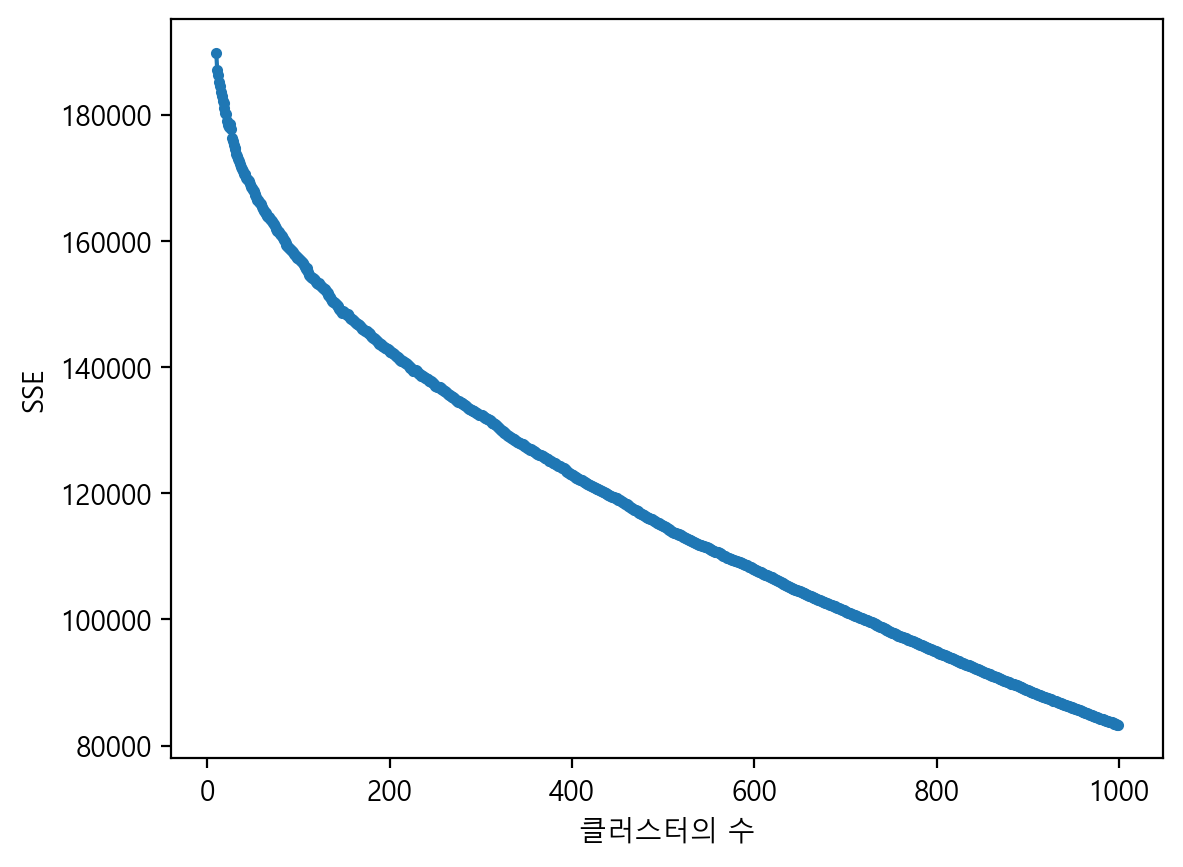

In [67]:
# 엘보우 방법을 사용하여 최적의 K값 탐색

# 1. 각 K값에 대한 SSE 값을 저장할 빈 리스트 생성
sse = []

start_num = 10
finish_num = 1000

for k in range(start_num, finish_num):  # 클러스터의 개수 (K)를 start_num부터 finish_num까지 변화시키면서 SSE 값 계산
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(kobart_contexts)
    sse.append(kmeans.inertia_)         # inertia_: KMeans 모델이 계산한 SSE 값

# SSE 그래프 확인
plt.plot(range(start_num, finish_num), sse, marker='o', markersize=3)
plt.xlabel('클러스터의 수')
plt.ylabel('SSE')
plt.show()

<br><br><br><hr>

## **✅06-2. 최적의 K값 찾기: 실루엣 분석**

<br>

### ***KoBERT--------------------------------------------------------***

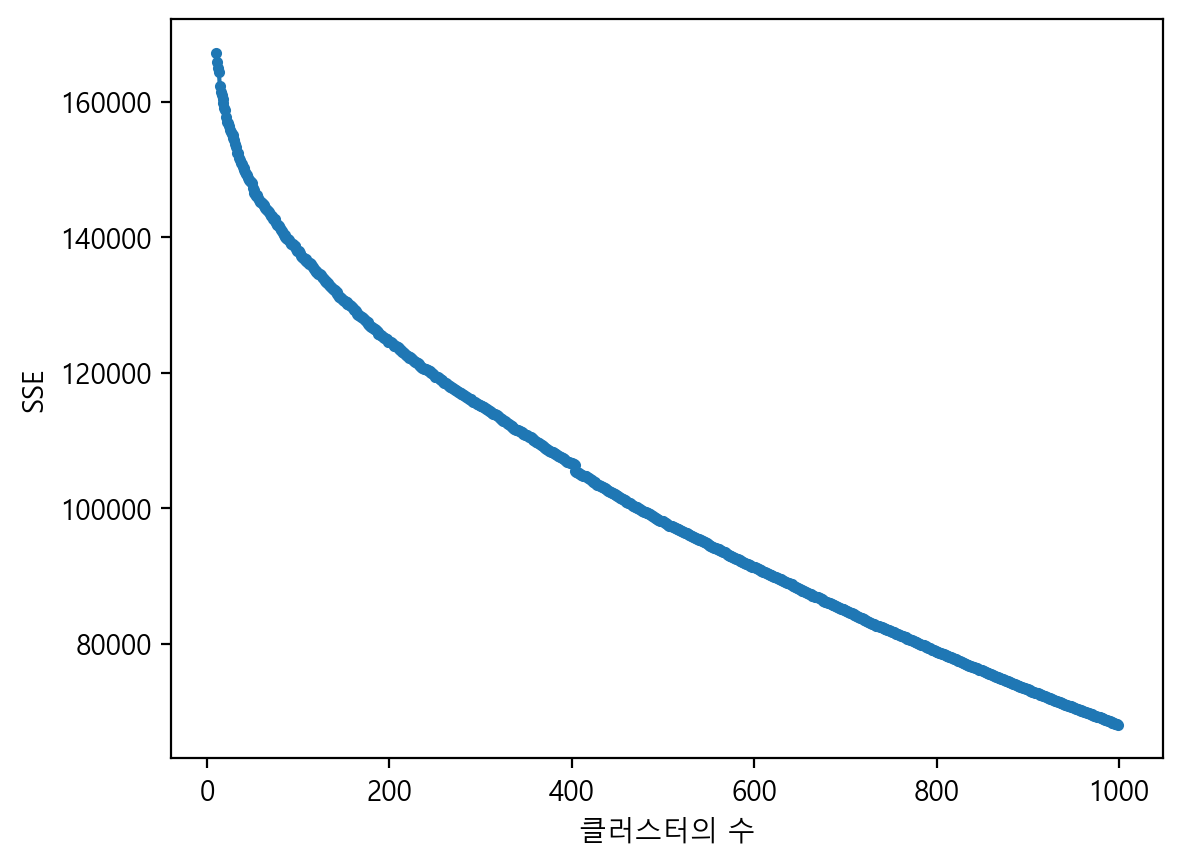

In [89]:
# 실루엣 분석을 사용하여 최적의 K값 탐색
silhouette_scores = []

for k in range(start_num, finish_num):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(kobert_contexts)
    score = silhouette_score(kobert_contexts, kmeans.labels_)
    silhouette_scores.append(score)

# 실루엣 분석 그래프 확인
plt.plot(range(start_num, finish_num), sse, marker='o', markersize=3)
plt.xlabel('클러스터의 수')
plt.ylabel('SSE')
plt.show()

<br><br><br><hr>

## **✅07. K-means Clustering**

<br>

### ***KoBART--------------------------------------------------------***
- KoBART로 생성한 영화 줄거리 벡터를 입력으로 K-means 클러스터링 수행

In [46]:
# kmeans 클러스터링 진행
n_clusters = 30
clt = KMeans(n_clusters=n_clusters)
clt.fit(kobart_contexts)

KMeans(n_clusters=30)

In [47]:
# 중심점 간의 거리를 교차 계산
# centroids의 좌표를 담고 있는 배열 
# e.g. (클러스터의 수, 차원) == (15, 768)
kobart_centroid = clt.cluster_centers_.astype(np.int64())

# 중심점들 간의 유클리디안 거리 계산 (15, 15)
kobart_dist = cdist(kobart_centroid, kobart_centroid)
kobart_centroid.shape

(30, 768)

In [48]:
# 각 VOD 콘텐츠별로 소속 클러스터로 매핑

# 각 데이터가 어떤 클러스터에 소속되어있는지 예측
kobart_xdata = clt.predict(kobart_contexts)
# 1차원 형태의 배열을 2차원 배열로 변환 (x, 1) 형태
kobart_xdata = kobart_xdata.reshape(kobart_xdata.shape[0], 1)

kobart_xdata.shape

(3675, 1)

<br><br><br>

### ***KoBERT--------------------------------------------------------***

- KoBERT로 생성한 영화 줄거리 벡터를 입력으로 K-means 클러스터링 수행

In [29]:
# kmeans 클러스터링 진행
n_clusters = 35
clt = KMeans(n_clusters=n_clusters)
clt.fit(kobert_contexts)

NameError: name 'kobert_contexts' is not defined

In [143]:
# 중심점 간의 거리를 교차 계산
# centroids의 좌표를 담고 있는 배열 
# e.g. (클러스터의 수, 차원) == (15, 768)
kobert_centroid = clt.cluster_centers_.astype(np.int64())

# 중심점들 간의 유클리디안 거리 계산 (15, 15)
kobert_dist = cdist(kobert_centroid, kobert_centroid)
kobert_centroid.shape

(35, 768)

In [144]:
# 각 VOD 콘텐츠별로 소속 클러스터로 매핑

# 각 데이터가 어떤 클러스터에 소속되어있는지 예측
kobert_xdata = clt.predict(kobert_contexts)
# 1차원 형태의 배열을 2차원 배열로 변환 (x, 1) 형태
kobert_xdata = kobert_xdata.reshape(kobert_xdata.shape[0], 1)

kobert_xdata.shape

(3675, 1)

<br><br><br><hr>

## **✅08. 클러스터별 데이터 확인**

<br>

### ***KoBART--------------------------------------------------------***

In [49]:
def kobart_display_cluster_image(cnum=0):
  # 해당 클러스터의 데이터 인덱스 찾기
  kobart_cluster_indices = np.where(kobart_xdata == cnum)[0]

  # 해당 클러스터에 포함된 데이터 출력
  kobart_cluster_data = data.iloc[kobart_cluster_indices][['asset_nm_전처리', 'genre_of_ct_cl']]
  print(f"\nCluster {cnum}:")
  print(kobart_cluster_data)
  print("")

  # 클러스터 벡터 추출
  kobart_cluster_embeddings = kobart_contexts[kobart_xdata.flatten() == cnum]

  # 코사인 유사도 계산
  kobart_similarities = cosine_similarity(kobart_cluster_embeddings)

  # 히트맵으로 시각화
  plt.figure(figsize=(10, 10))
  sns.heatmap(kobart_similarities,
              # annot=True,
              # fmt='.2f',
              # annot_kws={'size':8},
              cmap='Blues',
              square=True,
              linewidth=.1,
              cbar_kws={"shrink": .6})  # 컬러바 크기 줄이기
  plt.title(f"군집 {cnum}의 코사인 유사도 히트맵 시각화")
  plt.show()


ipywidgets.interact(kobart_display_cluster_image, cnum=(0, n_clusters-1, 1))
# cnum: 해당 클러스터에 포함된 영화 제목 출력

interactive(children=(IntSlider(value=0, description='cnum', max=29), Output()), _dom_classes=('widget-interac…

<function __main__.kobart_display_cluster_image(cnum=0)>

In [164]:
# neural network가 차원축소를 굉장히 잘 해줌
# 복잡한 문장을 768개의 벡터로 차원 축소하여 축소된 공간 안에 텍스트의 문맥이 들어있음
# 클러스터링 알고리즘을 사용하여 데이터를 확인할 수 있음
# 하지만 차원이 넓고 데이터 차원이 적은 경우 k-means보다 dbscan 방식이 소집단이 모여있는 공간으로 찾아갈 가능성이 높다
# kmeans는 처음에 뿌려진 random 값의 위치에 따라서 이질적인 문장들이 같은 클러스터로 구분될 가능성이 있음

<br><br><br>

### ***KoBERT--------------------------------------------------------***

In [96]:
def kobert_display_cluster_image(cnum=0):
  # 해당 클러스터의 데이터 인덱스 찾기
  kobert_cluster_indices = np.where(kobert_xdata == cnum)[0]

  # 해당 클러스터에 포함된 데이터 출력
  kobert_cluster_data = data.iloc[kobert_cluster_indices][['asset_nm_전처리', 'genre_of_ct_cl']]
  print(f"\nCluster {cnum}:")
  print(kobert_cluster_data)
  print("")

  # 클러스터 벡터 추출
  kobert_cluster_embeddings = kobert_contexts[kobert_xdata.flatten() == cnum]

  # 코사인 유사도 계산
  kobert_similarities = cosine_similarity(kobert_cluster_embeddings)

  # 히트맵으로 시각화
  plt.figure(figsize=(12, 12))
  sns.heatmap(kobert_similarities,
              # annot=True,
              # fmt='.2f',
              # annot_kws={'size':8},
              cmap='Blues',
              square=True,
              linewidth=.1)
  plt.title(f"군집 {cnum}의 코사인 유사도 히트맵 시각화")
  plt.show()


ipywidgets.interact(kobert_display_cluster_image, cnum=(0, n_clusters-1, 1))
# cnum: 해당 클러스터에 포함된 영화 제목 출력

interactive(children=(IntSlider(value=0, description='cnum', max=24), Output()), _dom_classes=('widget-interac…

<function __main__.kobert_display_cluster_image(cnum=0)>

<br><br><br><hr>

## **✅09. 군집별 빈도수 top10 단어 확인 및 워드클라우드 시각화**
- [색상표참고](https://coolhamstersneversleep.tistory.com/entry/Python-%EC%9B%8C%EB%93%9C%ED%81%B4%EB%9D%BC%EC%9A%B0%EB%93%9C-%EC%83%89%EC%83%81%ED%91%9C)

In [50]:
# stopwords 가져오기
with open('..\data\stopwords\combined_stopwords.txt', 'r', encoding='utf-8') as stopwords_file:
    custom_stopwords = stopwords_file.read().splitlines()

In [51]:
# 불용어 리스트에 해지, 시청, 가능, 서비스 추가
additional_stop_words = ['해지', '시청', '가능', '서비스', '평생', '소장', '시작', '사랑',
                         '더', '말', '다시', '사람', '사건', '곳', '없다', '그렇다']
custom_stopwords.extend(additional_stop_words)

In [52]:
from collections import Counter
from konlpy.tag import Okt
from wordcloud import WordCloud

In [53]:
okt = Okt()

<br>

### ***KoBART--------------------------------------------------------***

In [58]:
def kobart_display_cluster_info(cnum=0):
    # 해당 클러스터의 데이터 인덱스 찾기
    kobart_cluster_indices = np.where(kobart_xdata == cnum)[0]

    # 해당 클러스터 데이터 추출
    kobart_cluster_data = data.iloc[kobart_cluster_indices]['summary_최신순']

    # 클러스터에 속한 값의 개수 계산
    cluster_size = len(kobart_cluster_indices)

    # 클러스터 내 모든 줄거리 텍스트를 합치기
    kobart_combined_text = " ".join(kobart_cluster_data)

    # Okt로 명사 추출
    kobart_nouns = okt.nouns(kobart_combined_text)

    # 불용어 제거
    filtered_nouns = [noun for noun in kobart_nouns if noun not in custom_stopwords]
    
    # 명사 빈도 계산
    noun_counts = Counter(filtered_nouns)

    # 단어가 없는 경우 처리
    if not noun_counts:
        print(f"\nCluster {cnum}: 유효한 단어가 없습니다.")
        return
    
    # Top 20 명사 추출
    top_nouns = noun_counts.most_common(20)

    # 결과 출력
    print(f"\nCluster {cnum}({cluster_size})의 Top 20 명사:")
    for noun, count in top_nouns:
        print(f"{noun}: {count}")

    # 워드클라우드 데이터 생성
    wordcloud = WordCloud(
        font_path='../etc/D2Coding-Ver1.3.2-20180524.ttf',
        width=1000, 
        height=600, 
        background_color='white',
        colormap='Set2'
    ).generate_from_frequencies(noun_counts)

    # 워드클라우드 시각화
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"KoBART - Cluster {cnum}의 명사 워드클라우드 ({cluster_size})")
    plt.show()
    
# ipywidgets로 군집 선택
ipywidgets.interact(kobart_display_cluster_info, cnum=(0, n_clusters - 1, 1))

interactive(children=(IntSlider(value=0, description='cnum', max=29), Output()), _dom_classes=('widget-interac…

<function __main__.kobart_display_cluster_info(cnum=0)>

<br><br><br>

### ***KoBERT--------------------------------------------------------***

In [86]:
def kobert_display_cluster_info(cnum=0):
    # 해당 클러스터의 데이터 인덱스 찾기
    kobert_cluster_indices = np.where(kobert_xdata == cnum)[0]

    # 해당 클러스터 데이터 추출
    kobert_cluster_data = data.iloc[kobert_cluster_indices]['summary_최신순']

    # 클러스터에 속한 값의 개수 계산
    cluster_size = len(kobert_cluster_indices)

    # 클러스터 내 모든 줄거리 텍스트를 합치기
    kobert_combined_text = " ".join(kobert_cluster_data)

    # Okt로 명사 추출
    kobert_nouns = okt.nouns(kobert_combined_text)

    # 불용어 제거
    filtered_nouns = [noun for noun in kobert_nouns if noun not in custom_stopwords]
    
    # 명사 빈도 계산
    noun_counts = Counter(filtered_nouns)

    # 단어가 없는 경우 처리
    if not noun_counts:
        print(f"\nCluster {cnum}: 유효한 단어가 없습니다.")
        return
    
    # Top 20 명사 추출
    top_nouns = noun_counts.most_common(20)

    # 결과 출력
    print(f"\nCluster {cnum}({cluster_size})의 Top 20 명사:")
    for noun, count in top_nouns:
        print(f"{noun}: {count}")

    # 워드클라우드 데이터 생성
    wordcloud = WordCloud(
        font_path='../etc/D2Coding-Ver1.3.2-20180524.ttf',
        width=1000, 
        height=600, 
        background_color='white',
        colormap='Set2'
    ).generate_from_frequencies(noun_counts)

    # 워드클라우드 시각화
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"KoBERT - Cluster {cnum}의 명사 워드클라우드 ({cluster_size})")
    plt.show()
    
# ipywidgets로 군집 선택
ipywidgets.interact(kobert_display_cluster_info, cnum=(0, n_clusters - 1, 1))

interactive(children=(IntSlider(value=0, description='cnum', max=49), Output()), _dom_classes=('widget-interac…

<function __main__.kobert_display_cluster_info(cnum=0)>

<br><br><br><hr>

## **✅+) 형용사를 추가해서 빈도수 확인 및 워드클라우드 시각화**

<br><br><br>

### ***KoBART--------------------------------------------------------***

In [55]:
def kobart_display_cluster_with_adj(cnum=0):
    kobart_cluster_indices = np.where(kobart_xdata == cnum)[0]
    kobart_cluster_data = data.iloc[kobart_cluster_indices]['summary_최신순']
    cluster_size = len(kobart_cluster_indices)
    kobart_combined_text = " ".join(kobart_cluster_data)
    
    # Okt로 명사와 형용사 추출
    kobart_pos = okt.pos(kobart_combined_text, norm=True, stem=True)  # 형태소 분석 (표준화 및 어근화)
    kobart_words = [word for word, tag in kobart_pos if tag in ['Noun', 'Adjective']]  # 명사와 형용사 필터링

    filtered_words = [word for word in kobart_words if word not in custom_stopwords]
    word_counts = Counter(filtered_words)
    top_words = word_counts.most_common(10)

    print(f"\nCluster {cnum}({cluster_size})의 Top 10 명사/형용사:")
    for word, count in top_words:
        print(f"{word}: {count}")

    wordcloud = WordCloud(
        font_path='../etc/D2Coding-Ver1.3.2-20180524.ttf',
        width=1000, 
        height=600, 
        background_color='white',
        colormap='Set2'
    ).generate_from_frequencies(word_counts)

    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"KoBART - Cluster {cnum}의 명사+형용사 워드클라우드 ({cluster_size})")
    plt.show()
    
# ipywidgets로 군집 선택
ipywidgets.interact(kobart_display_cluster_with_adj, cnum=(0, n_clusters - 1, 1))

interactive(children=(IntSlider(value=0, description='cnum', max=29), Output()), _dom_classes=('widget-interac…

<function __main__.kobart_display_cluster_with_adj(cnum=0)>

<br><br><br>

### ***KoBERT--------------------------------------------------------***

In [261]:
def kobert_display_cluster_with_adj(cnum=0):
    kobert_cluster_indices = np.where(kobert_xdata == cnum)[0]
    kobert_cluster_data = data.iloc[kobert_cluster_indices]['summary_최신순']
    cluster_size = len(kobert_cluster_indices)
    kobert_combined_text = " ".join(kobert_cluster_data)

    # Okt로 명사와 형용사 추출
    kobert_pos = okt.pos(kobert_combined_text, norm=True, stem=True)  # 형태소 분석 (표준화 및 어근화)
    kobert_words = [word for word, tag in kobert_pos if tag in ['Noun', 'Adjective']]  # 명사와 형용사 필터링

    filtered_words = [word for word in kobert_words if word not in custom_stopwords]
    word_counts = Counter(filtered_words)

    # 단어가 없는 경우 처리
    if not word_counts:
        print(f"\nCluster {cnum}: 유효한 단어가 없습니다.")
        return
    
    top_words = word_counts.most_common(20)

    print(f"\nCluster {cnum}({cluster_size})의 Top 20 명사/형용사:")
    for word, count in top_words:
        print(f"{word}: {count}")

    wordcloud = WordCloud(
        font_path='../etc/D2Coding-Ver1.3.2-20180524.ttf',
        width=1000, 
        height=600, 
        background_color='white',
        colormap='Set2'
    ).generate_from_frequencies(word_counts)

    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"KoBERT - Cluster {cnum}의 명사+형용사 워드클라우드 ({cluster_size})")
    plt.show()
    
# ipywidgets로 군집 선택
ipywidgets.interact(kobert_display_cluster_with_adj, cnum=(0, n_clusters - 1, 1))

interactive(children=(IntSlider(value=0, description='cnum', max=49), Output()), _dom_classes=('widget-interac…

<function __main__.kobert_display_cluster_with_adj(cnum=0)>

<br><br><br><hr>

## **✅10. 사용자 입력**

- 사용자 입력 텍스트를 기반으로 가장 가까운 군집을 찾는 함수 정의
- 가장 가까운 군집의 번호와 해당 군집과의 거리 (유사도) return

In [56]:
def find_closest_cluster(user_input, tokenizer, centroids, xdata, data):
    # 1. 사용자 입력값 토크나이징
    inputs = tokenizer([user_input], return_tensors='pt')
  
    # 모델을 통해 임베딩 벡터 생성
    outputs = kobart_model(inputs['input_ids'], attention_mask=inputs['attention_mask'])

    # 첫 번째 토큰의 벡터를 저장
    user_vector = outputs.encoder_last_hidden_state.detach().numpy()[0, 0, :]

    # 군집 중심점과 사용자 입력 벡터 간 코사인 유사도 계산
    similarities = cosine_similarity([user_vector], centroids)

    # 가장 가까운 군집 찾기
    closest_cluster = np.argmax(similarities)
    closest_similarity = np.max(similarities)

    # 가장 가까운 군집에 속한 영화 제목 가져오기
    cluster_indices = np.where(xdata == closest_cluster)[0]
    cluster_titles = data.iloc[cluster_indices]['asset_nm_전처리']

    # 랜덤으로 10개의 영화 제목 선택
    random_titles = cluster_titles.sample(n=min(10, len(cluster_titles))).tolist()

    # 결과 출력
    print(f"가장 가까운 군집: Cluster {closest_cluster}")
    print(f"유사도: {closest_similarity:.4f}")
    print(f"\n{closest_cluster}번 군집에 속한 영화:")
    for title in random_titles:
        print(f"- {title}")

In [57]:
user_input = "미국 뉴욕 배경의 스파이 영화"

find_closest_cluster(
    user_input=user_input, 
    tokenizer=kobart_tokenizer, 
    centroids=clt.cluster_centers_,
    xdata=kobart_xdata, 
    data=data
)

가장 가까운 군집: Cluster 20
유사도: 0.6466

20번 군집에 속한 영화:
- 10일간의 애인
- 원 세컨드
- 블랙 앤 블루
- 허황옥 3일, 잃어버린 2천 년의 기억
- 인질
- 엔젤 해즈 폴른
- 지옥만세
- 49
- 시카다 3301
- 택시운전사


In [121]:
pd.options.display.max_colwidth = None

data[data['asset_nm_전처리']=='스트레스 제로']

,asset_nm_전처리,genre_of_ct_cl,summary_최신순
3361,스트레스 제로,애니메이션,어느 날 도심 곳곳에 정체를 알 수 없는 거대한 불괴물이 나타나 대한민국은 혼란에 빠진다 불괴물의 습격으로 졸지에 직장을 잃은 짱돌은 친구 고박사 타조와 함께 스트레스 제로를 팔아 백수 탈출을 하고자 하지만 이 음료가 바로 불괴물을 막을 수 있는 유일한 비밀임을 알게 되는데 갑자기 히어로가 된 아빠 짱돌과 친구들은 과연 불괴물을 잡고 세상을 구할 수 있을까


<hr>

#### *줄거리 TEST*  
"마을에서 일어난 미스터리한 살인 사건."  
"소년이 꿈을 찾아 떠나는 이야기."  
"우주의 침략자들과의 대결."  
"작은 마을의 따뜻한 가족 이야기."  
"사랑과 전쟁 사이에 놓인 두 연인의 운명."  

"어느 날 갑자기 나타난 외계인으로 인해 세계가 혼란에 빠진다. 주인공은 이를 막기 위해 노력한다."  
"한 소녀가 과거의 비밀을 찾아 떠나며 성장하는 과정을 그린 감동적인 이야기."  
"도시에서 벌어진 연쇄 살인 사건을 추적하는 형사와 그의 파트너."  
"과학자가 시간 여행을 가능하게 만들며 벌어지는 모험과 위기."  
"전설적인 검사가 법정에서 부패를 폭로하며 위협을 무릅쓰는 이야기."  
"거대한 로봇들이 지구를 침공하자, 사람들은 이를 막기 위해 힘을 합친다."  
"비밀스러운 섬에서 일어난 사건과 이를 해결하려는 탐정의 이야기."  
"어느 시골 마을에서 일어난 귀신의 전설과 이를 조사하는 사람들."  
"자신의 정체성을 찾아 떠나는 한 청년의 감동적인 여정."  
"왕국을 구하기 위해 모험에 나선 용감한 기사와 그의 동료들."   